### Plots for Final Report 

In [432]:
import pandas as pd
import numpy as np
import re
import os 
import matplotlib.pyplot as plt
output_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data/firing_rates'))
atlas_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'Analysis', 'atlas_data'))
model_dir = os.path.abspath(os.path.dirname(os.getcwd()))
figure_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'Analysis/Figures/thesis_figures'))
import ssm 
from ssm.plots import gradient_cmap
import yaml
import itertools
import scipy
# workaround to get a specific version of scipy signaltools
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import serotonin_functions
from scipy.stats import pearsonr
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib.patches import Rectangle
from stim_functions import figure_style

In [2]:
def load_firing_rates(output_dir, file_name):
    """
    Load data of firing rates
    output_dir: folder where the firing rates are saved
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))
    return ratesG

def extract_file_info(output_dir, file_name):
    
    # load settingsfile 
    settings_file = os.path.join(output_dir, file_name+'_expsettings.yml')
    
    with open(settings_file, 'r', encoding='utf8') as f_in:
        settings = yaml.safe_load(f_in)
        
    G = settings['Parameter']['G']
    S = settings['Parameter']['S']
    
    return [G, S]


def extract_session_nr(filename):
    '''
    Extract the session number from the file name.
    '''
        
    pattern = r'sessions_(\d+)'

    # use re.search to find the first occurrence of the pattern in the filename
    match = re.search(pattern, filename)

    if match:
        session = match.group(1)
    else:
        session = None
        
    return session


def compute_transitions(G_params, S_params, regions='all', window_length=4000, pre_stim=1000, sessions=range(10), thetaE=-1, beta=6, extra=''):
    ''' 
    For each window of serotonin stimulation, calculate the downstate probability and state change probablility.
    G_params: list of G parameter 
    S_params: list of S parameter 
    region: brain region
    window_length: length of window around stimulation onset
    pre_stim: time to plot before stimulation onset (subtracted from entire window in the end)
    '''
    
    times = np.arange(-pre_stim, window_length-pre_stim, 1)
    all_windows = pd.DataFrame()
    state_trans_df = pd.DataFrame()
    sessions = sessions 
    state_all_windows = pd.DataFrame()
    
    acronyms = ['Amyg', 'Hipp', 'mPFC', 'MRN', 'OLF', 'OFC', 'PAG', 'Pir', 'RSP', 'M2', 'SC', 'Str', 'Thal', 'VIS']
    
    if regions=='all':
        regions = range(14)


    for S in S_params:
        for G in G_params:
            p_state_change_all = []
           
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions' 
            for session in sessions:
                
                for region in regions:
                
                    file_dir = os.path.join(output_dir, session_name)
                    file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions_{session}'
                    states = pd.read_csv(os.path.join(file_dir, file_name+'_states.csv'), index_col=0)
                    states_region = states[states['region']==region]
                    # get the time window around the stimulation 
                    times_array = pd.read_csv(os.path.join(file_dir, file_name+'_stimulation_times.csv')).to_numpy()

                    # first check if all time windows are big enough 
                    # (e.g., sometimes the last simulation is too close to the end of the trial)
                    windows = []
                    for win in times_array:
                        start = win[0] - pre_stim
                        state_window = states_region[start:start+window_length]
                        if len(state_window) == window_length:
                            windows.append(start)


                    for i, start in enumerate(windows):
                        state_window = states_region[start:start+window_length]

                        # the state changes
                        zhat = state_window['state']
                        state_change_up = np.concatenate((np.diff(zhat) > 0, [False])).astype(int)
                        state_change_down = np.concatenate((np.diff(zhat) < 0, [False])).astype(int)

                        state_all_windows = pd.concat((state_all_windows, pd.DataFrame(data={'session': session, 'window': i, 'p_down':state_window['p_down'],
                                                                                 'p_state_change_up': state_change_up, 'p_state_change_down': state_change_down,
                                                                                 'time':times, 'state':zhat,
                                                                                 'region':region, 'abr_region': acronyms[region],
                                                                                 'G' : G, 'S' : S})))
                    
            
    # add the names of the regions to the dataset
    # for this load the atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    state_all_windows['region_name'] = atlas[np.array(state_all_windows['region'].values, dtype=int)]
    
    # also add the acronyms for every region
    #region_acronyms = pd.read_csv(os.path.join(atlas_dir, 'atlas_translation.csv'))
    #region_acronyms.drop(['Unnamed: 0'], inplace=True, axis=1)
    #region_acronyms = np.array(region_acronyms)
    #state_all_windows['abr_region'] = region_acronyms[np.array(state_all_windows['region'].values, dtype=int)]
    
    #acronyms = ['Amyg', 'Hipp', 'mPFC', 'MRN', 'OLF', 'OFC', 'PAG', 'Pir', 'RSP', 'M2', 'SC', 'Str', 'Thal', 'VIS']
    
    #for i, region_name in enumerate(regions):
    #    state_all_windows.loc[average_df['region_name'] == region_name, 'abr_region'] = acronyms[i]
    

    # add info about drn connectivity
    drn_connect = pd.read_csv(os.path.join(model_dir, 'drn_connectivity_cre-True_hemi-3_grouping-median_thresh-0.005.csv'))
    drn_connect = np.array(drn_connect)
    state_all_windows['drn_connect'] = drn_connect[np.array(state_all_windows['region'].values, dtype=int)]
    
    return state_all_windows 


In [433]:
region_acronyms = pd.read_csv(os.path.join(atlas_dir, 'atlas_translation.csv'))
region_acronyms.drop(['Unnamed: 0'], inplace=True, axis=1)
region_acronyms = np.array(region_acronyms)

In [434]:
region_acronyms

array([['RT', 'RT', 262, 'Thalamus'],
       ['ORBl', 'ORBl2/3', 412, 'Orbitofrontal cortex'],
       ['RSPv', 'RSPv5', 687, 'Retrosplenial cortex'],
       ['CA3', 'CA3so', 486, 'Hippocampus'],
       ['CA3', 'CA3slu', 479, 'Hippocampus'],
       ['DG', 'DGlb-po', 782, 'Hippocampus'],
       ['RSPd', 'RSPd2/3', 434, 'Retrosplenial cortex'],
       ['SSp-bfd', 'SSp-bfd4', 1047, 'Barrel cortex'],
       ['SCm', 'SCiw', 17, 'Superior colliculus'],
       ['VISp', 'VISp2/3', 821, 'Visual cortex'],
       ['VISp', 'VISp5', 778, 'Visual cortex'],
       ['PL', 'PL5', 363, 'Medial prefrontal cortex'],
       ['ACAd', 'ACAd5', 1015, 'Medial prefrontal cortex'],
       ['VISpm', 'VISpm2/3', 41, 'Visual cortex'],
       ['DP', 'DP5', 646, 'Olfactory areas'],
       ['DP', 'DP6a', 267, 'Olfactory areas'],
       ['COAa', 'COAa2', 200, 'Amygdala'],
       ['VISpm', 'VISpm6b', 469, 'Visual cortex'],
       ['DG', 'DG-po', 10704, 'Hippocampus'],
       ['MEA', 'MEApd-b', 480, 'Amygdala'],
       ['

#### Results
1) the down state is induced by inhibiting the excitatory population 
2) coupling leads to indirect effects of serotonin

In [ ]:
# plot heatmap 

# x : DRN connection strength (areas sorted by connection strength)
# y : G coupling value
# color values : serotonin effect (averaged downstate probability in a window of 2 seconds)

In [290]:
# plot showing a summarized view of indirect and direct effects of serotonin

# x : DRN connection strength (areas sorted by connection strength)
# y : serotonin effect (averaged downstate probability in a window of 2 seconds)

G_params = [0, 1, 2, 3]
S = 40
beta = 6
thetaE = -1
extra = 'RateAdj1'
all_sessions = np.arange(0,10,1)
serotonin_analysis = pd.DataFrame()

In [291]:
# load data for all sessions 
for G in G_params:
    for session in all_sessions:

        # get session folder name
        session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions'
        file_dir = os.path.join(output_dir, session_name)
        file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions_{session}'

        # compute down state probability 
        data_df = compute_transitions([G], [S], extra=extra)
        serotonin_analysis = pd.concat((serotonin_analysis, data_df))

serotonin_analysis.to_csv(f'serotonin_analysis_all_regions_{S}_{G_params}_{extra}.csv', index=False)

In [70]:
serotonin_analysis = pd.read_csv(f'serotonin_analysis_all_regions_{S}_{G_params}_{extra}.csv')


KeyboardInterrupt



In [402]:
# trajectory of all regions
window_duration = 4000
pre_stim = 1000
regions = np.unique(serotonin_analysis['region_name'])

# take the mean for the combined regions 
state_transitions = serotonin_analysis.groupby(['region_name', 'S', 'session', 'G', 'time'], as_index=False).mean()

# compute bins
# for this find how many sessions there are in this set and how long one session is 
bin_size = 200
nr_sessions = len(np.unique(state_transitions['session']))
max_time = len(np.unique(state_transitions['time']))
nr_bins = max_time/bin_size
bins = np.linspace(-pre_stim, max_time-pre_stim, int(nr_bins), endpoint=False)

# compute the time points of the bins
digitized = np.digitize(np.unique(state_transitions['time']), bins, right=True)
state_transitions['bin'] = np.tile(digitized, nr_sessions*len(regions)*len([S])*len(G_params))

colors, dpi = figure_style()

data_grouped_bins = state_transitions.groupby(['region_name', 'session', 'bin', 'G', 'S'], as_index=False).mean()
data_grouped_bins['time'] = data_grouped_bins['time']/1000

# save data 
data_grouped_bins.to_csv(f'state_analysis_bins_{S}_{G_params}_{extra}.csv', index=False)

In [399]:

data_grouped_bins.to_csv(f'state_analysis_bins_{S}_{G_params}_{extra}.csv', index=False)

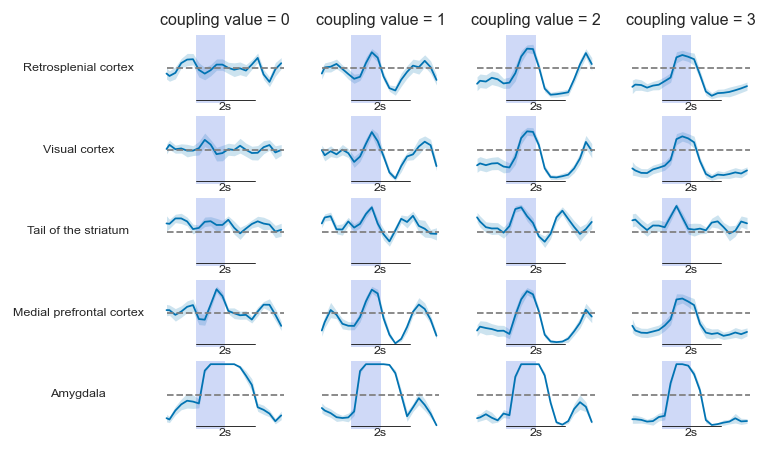

In [378]:
## plot
f, axs = plt.subplots(5, 4, figsize=(6, 4), dpi=dpi, sharey=True)
    
for i, region in enumerate(atlas_sorted[[0, 2, 3, 8, 13]]):
    
    for j, G in enumerate(G_params):
                
        data_df = data_grouped_bins[(data_grouped_bins['region_name'] == region)&(data_grouped_bins['G'] == G)]
        
        # now plot the trajectory 
        axs[i][j].axvspan(0, 1, alpha=0.25, color='royalblue', lw=0)
        sns.lineplot(data=data_df, x='time', y='p_down',
                         color=colors['suppressed'], errorbar='se', err_kws={'lw': 0}, ax=axs[i][j])
        axs[i][j].plot([-1, 3], [0.5, 0.5], ls='--', color='grey')
        
        sns.despine(trim=True, bottom=True, ax=axs[i][j])
        axs[i][j].plot([0, 2], [-0.01, -0.01], color='k', lw=0.5)
        axs[i][j].text(1, -0.03, '2s', ha='center', va='top')

        if j == 0:
            axs[i][j].text(-4, 0.6, region, ha='center', va='top')
            #axs[i][j].set(ylabel='Down state probability (%)')
        
        axs[i][j].axis('off')
        axs[i][j].get_yaxis().set_visible(False)
        axs[i][j].get_xaxis().set_visible(False)
            
        if i == 0:
            axs[i][j].set_title(f'coupling value = {G}', fontsize=9)
        

    #print(region, np.mean(data_grouped_bins[data_grouped_bins['region_name'] == region]['p_down']))
    
plt.savefig(f'all_trajectories{S}_selectedregions.jpg', bbox_inches="tight")

In [39]:
colors, dpi = figure_style()

In [38]:
import seaborn.objects as so
from matplotlib.colors import ListedColormap

In [188]:
data_grouped_bins['color'] = [colors[i] for i in data_grouped_bins['region_name']]
newcmp = ListedColormap(data_grouped_bins['color'])

C:\Users\gross\AppData\Local\Temp\ipykernel_13668\483873092.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_df = window_df.groupby(['G', 'S', 'drn_connect'], as_index=False).mean()


<AxesSubplot:xlabel='drn_connect', ylabel='G'>

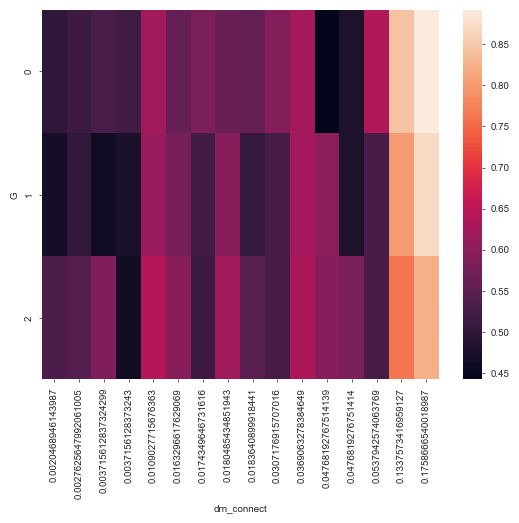

In [49]:
# only choose a 1.5 sec window for measuring the effect of serotonin
serotonin_window = [0,1.5]
window_df = data_grouped_bins[data_grouped_bins['time'].between(serotonin_window[0], serotonin_window[1])]

average_df = window_df.groupby(['G', 'S', 'drn_connect'], as_index=False).mean()

serotonin_matrix = average_df.pivot(index='G', columns='drn_connect', values='p_down')
sns.heatmap(serotonin_matrix)

<AxesSubplot:xlabel='G', ylabel='p_down'>

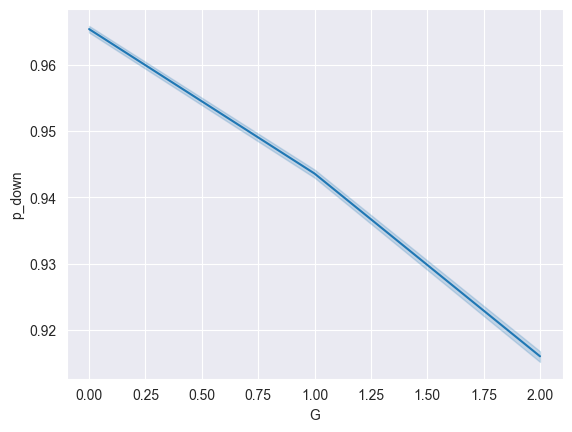

In [85]:
# per region plot 
region = 'Amygdala'
region_df = serotonin_analysis[serotonin_analysis['region_name']==region]

# mean over stimulation window
serotonin_window = [0,2000]
window_df = region_df[region_df['time'].between(serotonin_window[0], serotonin_window[1])]

sns.lineplot(window_df, x='G', y='p_down')


In [87]:
# get the DRN connectivity info 

drn_connect = pd.read_csv(os.path.join(model_dir, 'drn_connectivity_cre-True_hemi-3_grouping-median_thresh-0.005.csv'))

#### Plot with names

In [29]:
acronyms = ['Amyg', 'Hipp', 'mPFC', 'MRN', 'OLF', 'OFC', 'PAG', 'Pir', 'RSP', 'M2', 'SC', 'Str', 'Thal', 'VIS']

In [36]:
acronyms = ['Amyg', 'Hipp', 'mPFC', 'MRN', 'OLF', 'OFC', 'PAG', 'Pir', 'RSP', 'M2', 'SC', 'Str', 'Thal', 'VIS']
for i, region_name in enumerate(regions):
    average_df.loc[average_df['region_name'] == region_name, 'abr_region'] = acronyms[i]

C:\Users\gross\anaconda3\envs\iblenv\lib\_collections_abc.py:941: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\gross\anaconda3\envs\iblenv\lib\_collections_abc.py:941: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


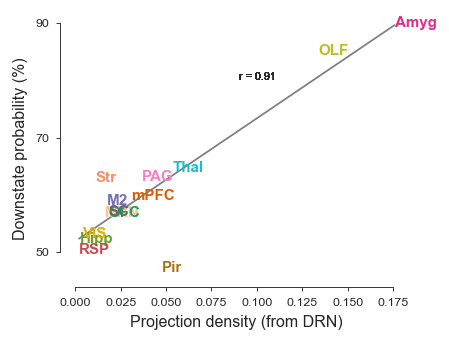

In [327]:
# average p_down 
serotonin_window = [0,1.5]
window_df = data_grouped_bins[data_grouped_bins['time'].between(serotonin_window[0], serotonin_window[1])]
uncoupled_stimulation_df = window_df[(window_df['G']==0) & (window_df['S']==40)]
average_prob_df = uncoupled_stimulation_df.groupby(['region_name'], as_index=False).mean()
average_prob_df['abr_region'] = acronyms
average_prob_df['color'] = [colors[i] for i in average_prob_df['region_name']]

f, ax = plt.subplots(1, 1,figsize=(3.5, 2.75), dpi=dpi)
(
     so.Plot(average_prob_df, x='drn_connect', y='p_down')
     .add(so.Dot(pointsize=0))
     .add(so.Line(color='grey', linewidth=1), so.PolyFit(order=1))
     .on(ax)
     .plot()
)


for i in average_prob_df.index:
    ax.text(average_prob_df.loc[i, 'drn_connect'], average_prob_df.loc[i, 'p_down'], average_prob_df.loc[i, 'abr_region'],
             color=average_prob_df.loc[i, 'color'], fontsize=8.5, fontweight='bold')
    #ax.set(yticks=[0.25, 0.5, 0.75, 1], xticks=[-0.0, 0.1, 0.2])
    r, p = pearsonr(average_prob_df['drn_connect'], average_prob_df['p_down'])
    ax.text(0.09, 0.8, f'r = {r:.2f}', fontsize=6)
    

plt.yticks([0.5, 0.7, 0.9], fontsize=9)
ax.set_yticklabels([50, 70, 90], fontsize=9)
plt.xlabel('Projection density (from DRN)', fontsize=9)
plt.ylabel('Downstate probability (%)', fontsize=9)
sns.despine(offset=2, trim=True)
plt.savefig('drnConnect_vs_pDown_G0_S40.pdf', bbox_inches="tight")

In [379]:
sensory_cortex_df = data_grouped_bins[data_grouped_bins['region_name'].isin(['Piriform','Visual cortex'])]
frontal_cortex_df = data_grouped_bins[data_grouped_bins['region_name'].isin(['Medial prefrontal cortex', 'Orbitofrontal cortex', 'Secondary motor cortex'])]
midbrain_df = data_grouped_bins[data_grouped_bins['region_name'].isin(['Periaqueductal gray', 'Midbrain reticular nucleus', 'Superior colliculus'])]

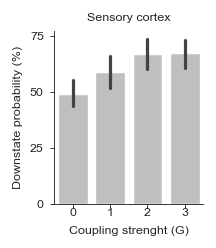

In [407]:
# define window of serotonin effect 
serotonin_window = [0.5,1.5]
sensory_cortex_serotonin_df = sensory_cortex_df[sensory_cortex_df['time'].between(serotonin_window[0],serotonin_window[1])] 
frontal_cortex_serotonin_df = frontal_cortex_df[frontal_cortex_df['time'].between(serotonin_window[0],serotonin_window[1])] 
midbrain_serotonin_df = midbrain_df[midbrain_df['time'].between(serotonin_window[0],serotonin_window[1])] 

areas_df = {'Sensory cortex' : sensory_cortex_serotonin_df, 'Frontal cortex' : frontal_cortex_serotonin_df,
            'Midbrain' : midbrain_serotonin_df}


colors, dpi = figure_style()
f, ax1 = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi=dpi)

# choose which area to plot 
plot_area = 'Sensory cortex'

sns.despine(trim=False)
sns.barplot(areas_df[plot_area], x='G', y='p_down', color=colors['grey'])
#ax1.plot([-0.5, 3.5], [0.5, 0.5], ls='--', color='grey')
ax1.tick_params(axis='x', which='major', pad=0)
ax1.set_xlabel('Coupling strenght (G)')
ax1.set_ylabel('Downstate probability (%)')
ax1.set_title(plot_area)
ax1.set_yticks([0, 0.25, 0.5, 0.75])
ax1.set_yticklabels([0, 25, 50, 75])
ax1.set_xticklabels(ax1.get_xticklabels())
plt.savefig(os.path.join(figure_dir, f'indirect_effect_{plot_area}_S40.pdf'), bbox_inches="tight")
plt.show()

#### Targets of Serotonin Stimulation

Plot:
1. histogram (4 bars for every target combination, y: projection density)
2. paradoxical response: plot the down state probablity over time for one example region (or all?)

In [133]:
# calculate the down state prob. for all combinations

serotonin_analysis = pd.read_csv(f'serotonin_analysis_all_regions_{S}_{G_params}_{extra}.csv')
serotonin_analysis_I = pd.read_csv(f'serotonin_analysis_all_regions_{S}_{G_params}_RateAdj1_I.csv')
serotonin_analysis_J = pd.read_csv(f'serotonin_analysis_all_regions_{S}_{G_params}_RateAdj1_J.csv')
serotonin_analysis_K = pd.read_csv(f'serotonin_analysis_all_regions_{S}_{G_params}_RateAdj1_K.csv')

targets = {'E-' : serotonin_analysis, 'I+' : serotonin_analysis_I, 'I-' : serotonin_analysis_J, 'E+' : serotonin_analysis_K}

In [211]:
# group data into time bins 
window_duration = 4500
pre_stim = 1000
regions = np.unique(serotonin_analysis['region_name'])
bin_size = 200
all_targets_df = pd.DataFrame()

for target_name, target_df in targets.items():
    # 
    # take the mean for the combined regions 
    state_transitions = target_df.groupby(['region_name', 'S', 'session', 'G', 'time'], as_index=False).mean()

    # compute bins
    # for this find how many sessions there are in this set and how long one session is 
    nr_sessions = len(np.unique(state_transitions['session']))
    max_time = len(np.unique(state_transitions['time']))
    nr_bins = max_time/bin_size
    bins = np.linspace(-pre_stim, max_time-pre_stim, int(nr_bins), endpoint=False)

    # compute the time points of the bins
    digitized = np.digitize(np.unique(state_transitions['time']), bins, right=True)
    state_transitions['bin'] = np.tile(digitized, nr_sessions*len(regions)*len([S])*len(G_params))

    data_grouped_bins = state_transitions.groupby(['region_name', 'session', 'bin', 'window', 'G'], as_index=False).mean()
    data_grouped_bins['time'] = data_grouped_bins['time']/1000

    data_grouped_bins['target_name'] = target_name
    
    all_targets_df = pd.concat((all_targets_df, data_grouped_bins))

In [415]:
G = 2

In [417]:
all_targets_df.to_csv(f'serotonin_targets_state_analysis_G{G}_S{S}.csv')

In [212]:
# only choose a 1.5 sec window for measuring the effect of serotonin
serotonin_window = [0,1.5]
window_df = all_targets_df[all_targets_df['time'].between(serotonin_window[0], serotonin_window[1])]

average_target_df = window_df.groupby(['target_name', 'session'], as_index=False).mean()

C:\Users\gross\AppData\Local\Temp\ipykernel_13668\1282972494.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_target_df = window_df.groupby(['target_name', 'session'], as_index=False).mean()


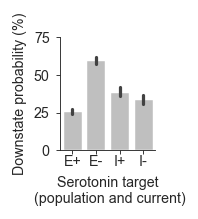

In [288]:
colors, dpi = figure_style()

f, ax1 = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi=dpi)

sns.despine(trim=False)
sns.barplot(average_target_df, x='target_name', y='p_down', color=colors['grey'])
ax1.tick_params(axis='x', which='major', pad=0)
ax1.set_xlabel('Serotonin target\n (population and current)', fontsize=8)
ax1.set_ylabel('Downstate probability (%)', fontsize=8)
ax1.set_yticks([0, 0.25, 0.5, 0.75])
ax1.set_yticklabels([0, 25, 50, 75], fontsize=8)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=8)
plt.tight_layout(pad=2, w_pad=5)
plt.savefig(os.path.join(figure_dir, 'barplot_targets_G2_S40.pdf'), bbox_inches="tight")
plt.show()

C:\Users\gross\AppData\Local\Temp\ipykernel_13668\429306860.py:16: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.lineplot(all_targets_df, x='time', y='p_down', hue='target_name', palette=sns.color_palette('Dark2'), ax=ax)


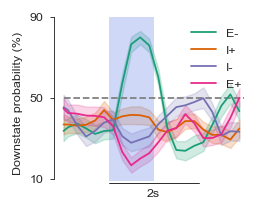

In [435]:
colors, dpi = figure_style()

G = 2
S = 40

fig, ax = plt.subplots(1, 1, figsize=(2, 1.75), dpi=dpi)

plt.axvspan(0, 1, alpha=0.25, ymin=0.05, color='royalblue', lw=0)#
ax.set_ylabel('Downstate probability (%)')
#sns.despine(offset=2, trim=False)
ax.get_xaxis().set_visible(False)
ax.set_ylim([0.05,0.9])
ax.plot([-1, 3], [0.5, 0.5], ls='--', color='grey')
ax.plot([0, 2], [0.08, 0.08], color='k', lw=0.5)
ax.text(1, 0.05, '2s', ha='center', va='top')
sns.lineplot(all_targets_df, x='time', y='p_down', hue='target_name', palette=sns.color_palette('Dark2'), ax=ax)
ax.set_yticks([0.1, 0.5, 0.9])
ax.set_yticklabels([10, 50, 90])
ax.legend(title=None, loc='upper right')
sns.despine(trim=True, bottom=True)
plt.savefig(os.path.join(figure_dir, f'trajectory_serotonin_targets_{G}_{S}.pdf'), bbox_inches="tight")
plt.show()